# OsmoFlux - Version 1
First attempt at the Python program from the Google spreadsheet.

**Design ideas**
- No sheet import/parsing.
- Axial segments are hydraulically in series, electrically in parallel.
- Electrical closure supports `mode='fixed_load'` and `mode='max_power'`.


## Variables
Constants, unit conversions, and model-wide options/toggles.

In [1]:
def axial_model_1d(params):
    """
    1D axial RED model with correct topology:
    - Axial segments: hydraulic series, electrical parallel
    - Cell pairs: hydraulic parallel, electrical series
    """

    # Unpack parameters
    N_SEG = params['N_SEG']
    N_cp  = params['N_cell_pairs']
    R_mem_cp = params['R_membrane_cp']
    E_cp = params['E_cell_pair']
    R_load = params['R_load']

    # Stack-level electrical quantities (cell pairs in series)
    E_stack = N_cp * E_cp
    R_stack = N_cp * R_mem_cp

    # Axial electrical scaling
    E_seg = E_stack / N_SEG
    R_seg = R_stack * N_SEG

    # Electrical aggregation: axial segments in parallel
    R_int_eq = R_seg / N_SEG

    I = E_stack / (R_int_eq + R_load)
    V = I * R_load
    P = I * V

    return {
        'E_stack': E_stack,
        'R_internal': R_int_eq,
        'Current': I,
        'Voltage': V,
        'Power': P,
    }


## nacl_conductivity
Spreadsheet-style NaCl conductivity correlation.
The function signature is:
`KAPPA_NACL_SI(c_mol_L, T_K) -> S_per_m`


In [2]:
# -------------------------
# NaCl conductivity (kappa)
# -------------------------

import numpy as np

# Molar mass of NaCl
MW_NACL_G_PER_MOL = 58.44277  # [g/mol]

# 25C table (Foxboro/Gilson), stored as mg/L -> conductivity at 25C
# Using the mS/cm column.
NACL_MG_L_TABLE = np.array([
    1, 3, 10, 30, 100, 300, 1000, 3000, 10000, 30000, 50000, 100000, 200000
], dtype=float)  # [mg/L]

NACL_KAPPA_MS_CM_25C_TABLE = np.array([
    0.0022, 0.0065, 0.0214, 0.064, 0.21, 0.617, 1.99, 5.69, 17.6, 48.6, 78.3, 140.0, 226.0
], dtype=float)  # [mS/cm] at 25C

# Unit conversion:
# 1 mS/cm = 0.1 S/m
MS_CM_TO_S_M = 0.1

# Optional temperature correction (OFF by default to match 25C data exactly)
# set USE_TEMP_CORRECTION = False
# and adjust TEMP_COEFF_PER_K to match the sheet.
USE_TEMP_CORRECTION = False
T_REF_K = 298.15
TEMP_COEFF_PER_K = 0.0212  # crude placeholder, only used if USE_TEMP_CORRECTION = False


def _mol_L_to_mg_L_nacl(c_mol_L: float) -> float:
    """Convert NaCl concentration from mol/L -> mg/L."""
    # mol/L * g/mol = g/L; *1000 => mg/L
    return float(c_mol_L) * MW_NACL_G_PER_MOL * 1000.0


def kappa_nacl_fit_default(c_mol_L: float, T_K: float) -> float:
    """
    Conductivity κ for aqueous NaCl.

    INPUTS:
      - c_mol_L: NaCl concentration [mol/L]
      - T_K: temperature [K]

    OUTPUT:
      - κ [S/m]

    Data basis:
      - Foxboro/Gilson table values at 25C (298.15 K), from sheet.

    Implementation:
      - Convert mol/L -> mg/L
      - Interpolate κ in log-log space versus mg/L
      - Convert mS/cm -> S/m
      - Optional temperature correction (disabled by default)
    """
    c = max(float(c_mol_L), 0.0)
    T = float(T_K)

    # Convert concentration to mg/L for lookup
    mg_L = _mol_L_to_mg_L_nacl(c)
    min_mg_L, max_mg_L = NACL_TABLE_RANGE_MG_L()
    is_out_of_range = (mg_L < min_mg_L) or (mg_L > max_mg_L)



    # Clamp to table range to avoid nonsense at extreme extrapolation
    mg_L_clamped = min(max(mg_L, NACL_MG_L_TABLE[0]), NACL_MG_L_TABLE[-1])

    # Convert table κ to SI [S/m]
    kappa_S_m_table = NACL_KAPPA_MS_CM_25C_TABLE * MS_CM_TO_S_M  # [S/m] at 25C

    # Log-log interpolation across decades
    x = np.log10(NACL_MG_L_TABLE)
    y = np.log10(kappa_S_m_table)
    kappa_25C = 10 ** np.interp(np.log10(mg_L_clamped), x, y)  # [S/m] at 25C

    if USE_TEMP_CORRECTION:
        # Simple linearized correction; replace with sheet’s exact rule if needed
        kappa = kappa_25C * max(1.0 + TEMP_COEFF_PER_K * (T - T_REF_K), 0.0)
    else:
        kappa = kappa_25C

    # Safety floor to avoid divide-by-zero elsewhere
    return float(max(kappa, 1e-9))


def KAPPA_NACL_SI(c_mol_L: float, T_K: float) -> float:
    """Public wrapper: NaCl conductivity in SI units [S/m]."""
    return kappa_nacl_fit_default(c_mol_L, T_K)


# Quick sanity checks against Google sheet table (at 25C):
# We convert mg/L -> mol/L and verify κ comes back close (interpolation exact on table points)
def _mg_L_to_mol_L_nacl(mg_L: float) -> float:
    return float(mg_L) / 1000.0 / MW_NACL_G_PER_MOL  # mg/L -> g/L -> mol/L

def NACL_TABLE_RANGE_MG_L() -> tuple[float, float]:
    """Return (min_mg_L, max_mg_L) covered by the conductivity table."""
    return float(NACL_MG_L_TABLE[0]), float(NACL_MG_L_TABLE[-1])


print("Sanity check vs table points (25C):")
for mg_L, ms_cm in zip(NACL_MG_L_TABLE, NACL_KAPPA_MS_CM_25C_TABLE):
    c_mol_L = _mg_L_to_mol_L_nacl(mg_L)
    kappa_pred_S_m = KAPPA_NACL_SI(c_mol_L, 298.15)
    kappa_true_S_m = ms_cm * MS_CM_TO_S_M
    rel_err = (kappa_pred_S_m - kappa_true_S_m) / kappa_true_S_m
    print(f"mg/L={mg_L:>7.0f}  κ_true={kappa_true_S_m:>10.6g} S/m  κ_pred={kappa_pred_S_m:>10.6g} S/m  rel_err={rel_err:+.2e}")

Sanity check vs table points (25C):
mg/L=      1  κ_true=   0.00022 S/m  κ_pred=   0.00022 S/m  rel_err=-2.46e-16
mg/L=      3  κ_true=   0.00065 S/m  κ_pred=   0.00065 S/m  rel_err=+3.34e-16
mg/L=     10  κ_true=   0.00214 S/m  κ_pred=   0.00214 S/m  rel_err=+4.05e-16
mg/L=     30  κ_true=    0.0064 S/m  κ_pred=    0.0064 S/m  rel_err=-2.71e-16
mg/L=    100  κ_true=     0.021 S/m  κ_pred=     0.021 S/m  rel_err=+0.00e+00
mg/L=    300  κ_true=    0.0617 S/m  κ_pred=    0.0617 S/m  rel_err=+1.12e-16
mg/L=   1000  κ_true=     0.199 S/m  κ_pred=     0.199 S/m  rel_err=+1.39e-16
mg/L=   3000  κ_true=     0.569 S/m  κ_pred=     0.569 S/m  rel_err=+0.00e+00
mg/L=  10000  κ_true=      1.76 S/m  κ_pred=      1.76 S/m  rel_err=+0.00e+00
mg/L=  30000  κ_true=      4.86 S/m  κ_pred=      4.86 S/m  rel_err=+0.00e+00
mg/L=  50000  κ_true=      7.83 S/m  κ_pred=      7.83 S/m  rel_err=+1.13e-16
mg/L= 100000  κ_true=        14 S/m  κ_pred=        14 S/m  rel_err=-1.27e-16
mg/L= 200000  κ_true=      2

## design_inputs (per run)
A run-specific parameter container.

This is the place to mirror sheet's **3-DesignInputs** tab variable names.

The class is immutable (`frozen=True`) so cloning is simple: `replace(params, FIELD=value)`.

In [3]:
# -------------------------
# Run-specific inputs
# -------------------------
@dataclass(frozen=True)
class DesignInputs:
    # ---- Core thermodynamics ----
    T_K: float = T_DEFAULT_K  # temperature [K]

    # ---- Stack topology ----
    N_CELL_PAIRS: int = 10  # number of cell pairs (variable per run) [count]
    A_MEM_M2: float = 0.5   # active membrane area per cell pair [m^2]
    
    # ---- Hydraulics ----
    # Volumetric flow rates for high-salinity (H) and low-salinity (L) streams
    Q_H_M3_S: float = 1.0e-5  # [m^3/s]
    Q_L_M3_S: float = 1.0e-5  # [m^3/s]

    # Inlet concentrations (NaCl), mol/L
    C_H_IN_MOL_L: float = 0.5   # [mol/L]
    C_L_IN_MOL_L: float = 0.02  # [mol/L]

    # ---- Channel geometry (used for solution resistance models) ----
    GAP_M: float = 200e-6     # intermembrane gap / spacer thickness [m]
    # model spacer porosity or tortuosity -- add here later

    # ---- Membrane / electrochemical parameters ----
    ALPHA_PERM: float = 0.9   # permselectivity factor (0..1)
    BETA: float = 1.0         # charge efficiency / salt transfer efficiency (0..1)
    
    # Area-specific resistances (ASR) [ohm*m^2] (typical spreadsheet inputs)
    ASR_AEM_OHM_M2: float = 2.0e-4  # [Ω·m^2]
    ASR_CEM_OHM_M2: float = 2.0e-4  # [Ω·m^2]

    # Optional extra ASR terms (spacer, electrodes, manifolds, contacts)
    ASR_EXTRA_OHM_M2: float = 0.0   # [Ω·m^2]

    # ---- External electrical closure ----
    MODE: Literal["fixed_load", "max_power"] = "fixed_load"
    R_LOAD_OHM: float = 5.0  # [Ω] used if MODE='fixed_load'

    # ---- 1D axial discretization ----
    N_SEG: int = 20  # number of axial segments [count]

    # Fixed-point initialization / stabilization (optional overrides per run)
    INIT_V_TERM_V: Optional[float] = None  # initial guess terminal voltage [V]

    # Placeholder for future cost & pumping parameters (add without refactor)
    # COST_MEMBRANE_PER_M2: float = 0.0
    # PRICE_ELECTRICITY_PER_KWH: float = 0.0
    # DELTA_P_PA: float = 0.0


def clone_params(p: DesignInputs, **updates) -> DesignInputs:
    """Convenience wrapper for sweeps. Equivalent to dataclasses.replace."""
    return replace(p, **updates)


# Display the exact fields (so we can align with the sheet)
print("DesignInputs fields:\n - " + "\n - ".join(DesignInputs.__dataclass_fields__.keys()))


DesignInputs fields:
 - T_K
 - N_CELL_PAIRS
 - A_MEM_M2
 - Q_H_M3_S
 - Q_L_M3_S
 - C_H_IN_MOL_L
 - C_L_IN_MOL_L
 - GAP_M
 - ALPHA_PERM
 - BETA
 - ASR_AEM_OHM_M2
 - ASR_CEM_OHM_M2
 - ASR_EXTRA_OHM_M2
 - MODE
 - R_LOAD_OHM
 - N_SEG
 - INIT_V_TERM_V


## built_in_functions
Helper functions shared by both models: Nernst potential, resistance building blocks, conversions, sanity checks.

In [4]:
# -------------------------
# Shared helpers
# -------------------------

def _clamp_conc(c_mol_L: float) -> float:
    if OPTIONS.CLAMP_CONC_POSITIVE:
        return max(float(c_mol_L), OPTIONS.CONC_FLOOR_MOL_L)
    return float(c_mol_L)


def NERNST_OCV_CELLPAIR_V(C_H_MOL_L: float, C_L_MOL_L: float, T_K: float, ALPHA_PERM: float) -> float:
    """Open-circuit voltage for a single cell pair [V].
    
    Typical spreadsheet form (ideal, monovalent):
      E_cell = 2 * α * (R*T/F) * ln( a_H / a_L )
    where α is permselectivity (0..1). Here a≈c if activity coefficients are ignored.
    """
    cH = _clamp_conc(C_H_MOL_L)
    cL = _clamp_conc(C_L_MOL_L)
    return float(2.0 * ALPHA_PERM * (R * T_K / F) * math.log(cH / cL))


def ASR_SOLUTION_OHM_M2(C_MOL_L: float, T_K: float, GAP_M: float) -> float:
    """Solution area-specific resistance [Ω·m^2] for one channel gap.
    
    Simple model:
      ASR_sol = GAP / κ
    where κ is conductivity [S/m].
    
    If the sheet uses a more detailed spacer model, replace this exactly.
    """
    kappa = KAPPA_NACL_SI(C_MOL_L, T_K)  # [S/m]
    return float(GAP_M / kappa)  # [Ω·m^2]


def ASR_CELLPAIR_OHM_M2(p: DesignInputs, C_H_MOL_L: float, C_L_MOL_L: float) -> float:
    """Total area-specific resistance per cell pair [Ω·m^2]."""
    asr_sol_H = ASR_SOLUTION_OHM_M2(C_H_MOL_L, p.T_K, p.GAP_M)
    asr_sol_L = ASR_SOLUTION_OHM_M2(C_L_MOL_L, p.T_K, p.GAP_M)
    return float(p.ASR_AEM_OHM_M2 + p.ASR_CEM_OHM_M2 + asr_sol_H + asr_sol_L + p.ASR_EXTRA_OHM_M2)


def R_STACK_INTERNAL_OHM(p: DesignInputs, C_H_MOL_L: float, C_L_MOL_L: float) -> float:
    """Internal resistance of the whole stack [Ω] at given concentrations."""
    asr = ASR_CELLPAIR_OHM_M2(p, C_H_MOL_L, C_L_MOL_L)   # [Ω·m^2] per cell pair
    r_cellpair = asr / p.A_MEM_M2                        # [Ω] per cell pair
    return float(p.N_CELL_PAIRS * r_cellpair)            # series


def E_STACK_OCV_V(p: DesignInputs, C_H_MOL_L: float, C_L_MOL_L: float) -> float:
    """Stack OCV [V] = N_CELL_PAIRS * E_cellpair."""
    e_cell = NERNST_OCV_CELLPAIR_V(C_H_MOL_L, C_L_MOL_L, p.T_K, p.ALPHA_PERM)
    return float(p.N_CELL_PAIRS * e_cell)


def salt_transfer_mol_per_s(I_A: float, N_CELL_PAIRS: int, BETA: float) -> float:
    """Faradaic NaCl transfer rate [mol/s] from H->L implied by current.
    
    For monovalent ions, charge flow I corresponds to mol/s = I/F.
    In a RED stack, each cell pair contributes; with N in series, current is common,
    so total mol/s transfer scales with N (spreadsheet convention often uses N).
    
    BETA is a catch-all for charge efficiency / leakage effects (0..1).
    """
    return float(BETA * I_A * N_CELL_PAIRS / F)


def apply_salt_balance(
    C_H_IN_MOL_L: float, C_L_IN_MOL_L: float,
    Q_H_M3_S: float, Q_L_M3_S: float,
    n_dot_mol_s: float
) -> Tuple[float, float]:
    """Update outlet concentrations from a segment given salt transfer n_dot [mol/s].
    
    Convention: +n_dot means NaCl moves from high-salinity stream to low-salinity stream.
    
    Mass balance:
      ΔC_H = -n_dot / Q_H   (mol/m^3) then convert to mol/L
      ΔC_L = +n_dot / Q_L
    """
    # mol/m^3
    dC_H_mol_m3 = -n_dot_mol_s / max(Q_H_M3_S, 1e-30)
    dC_L_mol_m3 = +n_dot_mol_s / max(Q_L_M3_S, 1e-30)

    # convert to mol/L
    dC_H_mol_L = dC_H_mol_m3 / L_PER_M3
    dC_L_mol_L = dC_L_mol_m3 / L_PER_M3

    C_H_OUT = C_H_IN_MOL_L + dC_H_mol_L
    C_L_OUT = C_L_IN_MOL_L + dC_L_mol_L

    # Clamp to non-negative if requested
    if OPTIONS.CLAMP_CONC_POSITIVE:
        C_H_OUT = max(C_H_OUT, OPTIONS.CONC_FLOOR_MOL_L)
        C_L_OUT = max(C_L_OUT, OPTIONS.CONC_FLOOR_MOL_L)

    return float(C_H_OUT), float(C_L_OUT)


def sanity_check_inputs(p: DesignInputs) -> None:
    assert p.N_CELL_PAIRS >= 1
    assert p.N_SEG >= 1
    assert p.A_MEM_M2 > 0
    assert p.Q_H_M3_S > 0 and p.Q_L_M3_S > 0
    assert p.C_H_IN_MOL_L > 0 and p.C_L_IN_MOL_L > 0
    assert 0 <= p.ALPHA_PERM <= 1.0
    assert 0 <= p.BETA <= 1.0
    assert p.GAP_M > 0


## 5) model functions
Two pure functions:
- `model_0d(params)`
- `model_1d_axial(params, mode=...)`

Return type: structured dict with both scalar outputs and per-segment arrays.
Axial model uses a fixed-point iterative loop with damping (no circular refs).

In [5]:
# -------------------------
# 0D model
# -------------------------
def model_0d(p: DesignInputs, mode: Optional[Literal["fixed_load", "max_power"]] = None) -> Dict[str, Any]:
    sanity_check_inputs(p)
    mode = mode or p.MODE

    # Treat as single lump with inlet concentrations
    C_H = p.C_H_IN_MOL_L
    C_L = p.C_L_IN_MOL_L

    E_ocv = E_STACK_OCV_V(p, C_H, C_L)         # [V]
    R_int = R_STACK_INTERNAL_OHM(p, C_H, C_L)  # [Ω]

    if mode == "fixed_load":
        R_load = float(p.R_LOAD_OHM)
        I = E_ocv / (R_int + R_load)  # [A]
        V_term = I * R_load           # [V]
    elif mode == "max_power":
        # Thevenin: max power when R_load = R_int
        R_load = R_int
        I = E_ocv / (R_int + R_load)
        V_term = I * R_load
    else:
        raise ValueError(f"Unknown mode: {mode}")

    P = V_term * I  # [W]

    n_dot = salt_transfer_mol_per_s(I, p.N_CELL_PAIRS, p.BETA)  # [mol/s]
    C_H_OUT, C_L_OUT = apply_salt_balance(C_H, C_L, p.Q_H_M3_S, p.Q_L_M3_S, n_dot)

    return {
        "mode": mode,
        "E_OCV_V": E_ocv,
        "R_INT_OHM": R_int,
        "R_LOAD_OHM": R_load,
        "V_TERM_V": V_term,
        "I_A": I,
        "P_W": P,
        "C_H_OUT_MOL_L": C_H_OUT,
        "C_L_OUT_MOL_L": C_L_OUT,
        "n_dot_salt_mol_s": n_dot,
    }


# -------------------------
# 1D axial model
# -------------------------
def _axial_branch_params(p: DesignInputs, C_H: float, C_L: float) -> Tuple[float, float]:
    """Return (E_seg, R_seg) for a segment given *local* concentrations."""
    E_seg = E_STACK_OCV_V(p, C_H, C_L)          # [V] stack OCV for that segment's local conditions
    R_seg = R_STACK_INTERNAL_OHM(p, C_H, C_L)   # [Ω] stack internal for that segment
    return float(E_seg), float(R_seg)


def model_1d_axial(
    p: DesignInputs,
    mode: Optional[Literal["fixed_load", "max_power"]] = None,
) -> Dict[str, Any]:
    """1D axial RED model.

    Hydraulics: segments in series (outlet of j feeds inlet of j+1).
    Electrical: segments in parallel (common terminal voltage V_term; branch currents distribute).

    Electrical closure:
      - fixed_load: V_term = I_total * R_LOAD_OHM
      - max_power: choose equivalent Thevenin load -> V_term = V_oc_eq/2
    """
    sanity_check_inputs(p)
    mode = mode or p.MODE
    N = int(p.N_SEG)

    # Arrays per segment (0..N-1)
    C_H_IN = np.zeros(N, dtype=float)
    C_L_IN = np.zeros(N, dtype=float)
    C_H_OUT = np.zeros(N, dtype=float)
    C_L_OUT = np.zeros(N, dtype=float)

    E_seg = np.zeros(N, dtype=float)      # [V]
    R_seg = np.zeros(N, dtype=float)      # [Ω]
    I_seg = np.zeros(N, dtype=float)      # [A]
    n_dot_seg = np.zeros(N, dtype=float)  # [mol/s]

    # Diagnostics / feasibility flags
    min_mg_L, max_mg_L = NACL_TABLE_RANGE_MG_L()
    any_kappa_oob = False
    any_conc_clamped = False
    any_inversion = False

    # Initialize hydraulic inlets
    C_H_IN[0] = p.C_H_IN_MOL_L
    C_L_IN[0] = p.C_L_IN_MOL_L

    # Initial guess for terminal voltage
    if p.INIT_V_TERM_V is not None:
        V_term = float(p.INIT_V_TERM_V)
    else:
        V_term = 0.5 * E_STACK_OCV_V(p, p.C_H_IN_MOL_L, p.C_L_IN_MOL_L)

    iter_diag = [] if OPTIONS.STORE_ITER_DIAGNOSTICS else None
    converged = False

    for it in range(OPTIONS.MAX_ITERS):
        V_old = V_term

        # Step 1: march hydraulically, compute local branch params and branch currents
        for j in range(N):
            if j > 0:
                C_H_IN[j] = C_H_OUT[j - 1]
                C_L_IN[j] = C_L_OUT[j - 1]

            # Track concentration validity vs kappa table (mg/L)
            mgL_H = _mol_L_to_mg_L_nacl(C_H_IN[j])
            mgL_L = _mol_L_to_mg_L_nacl(C_L_IN[j])
            if (mgL_H < min_mg_L) or (mgL_H > max_mg_L) or (mgL_L < min_mg_L) or (mgL_L > max_mg_L):
                any_kappa_oob = True

            # Local segment electrochem based on inlet concentrations (sheet often uses inlet or avg; adjust if needed)
            E_seg[j], R_seg[j] = _axial_branch_params(p, C_H_IN[j], C_L_IN[j])

            # Branch current given common V_term; clamp to non-negative (no reversal in this model)
            I_seg[j] = max((E_seg[j] - V_term) / max(R_seg[j], 1e-30), 0.0)

            # Salt transfer and outlet concentrations for this segment
            n_dot_seg[j] = salt_transfer_mol_per_s(I_seg[j], p.N_CELL_PAIRS, p.BETA)
            C_H_OUT[j], C_L_OUT[j] = apply_salt_balance(
                C_H_IN[j], C_L_IN[j], p.Q_H_M3_S, p.Q_L_M3_S, n_dot_seg[j]
            )

            # Clamp/inversion diagnostics
            if (C_H_OUT[j] <= OPTIONS.CONC_FLOOR_MOL_L + 1e-30) or (C_L_OUT[j] <= OPTIONS.CONC_FLOOR_MOL_L + 1e-30):
                any_conc_clamped = True
            if C_L_OUT[j] > C_H_OUT[j]:
                any_inversion = True

        # Step 2: electrical closure update V_term
        if mode == "fixed_load":
            I_total = float(np.sum(I_seg))
            V_new = I_total * float(p.R_LOAD_OHM)
        elif mode == "max_power":
            # Equivalent Thevenin from parallel branches (given local E/R)
            G = np.sum(1.0 / np.maximum(R_seg, 1e-30))  # [1/Ω]
            V_oc_eq = float(np.sum(E_seg / np.maximum(R_seg, 1e-30)) / max(G, 1e-30))
            V_new = 0.5 * V_oc_eq  # max-power choice
        else:
            raise ValueError(f"Unknown mode: {mode}")

        # Damped fixed-point update
        V_term = (1.0 - OPTIONS.DAMPING) * V_old + OPTIONS.DAMPING * V_new

        # Convergence check
        abs_err = abs(V_term - V_old)
        rel_err = abs_err / max(abs(V_old), 1e-12)

        if OPTIONS.STORE_ITER_DIAGNOSTICS:
            iter_diag.append({"iter": it, "V_term": V_term, "abs_err": abs_err, "rel_err": rel_err})

        if abs_err < OPTIONS.ABS_TOL or rel_err < OPTIONS.REL_TOL:
            converged = True
            break

    # Final totals
    I_total = float(np.sum(I_seg))
    P_total = float(V_term * I_total)

    # Equivalent internal resistance seen at terminals (parallel combination of R_seg)
    G_tot = float(np.sum(1.0 / np.maximum(R_seg, 1e-30)))
    R_int_eq = float(1.0 / max(G_tot, 1e-30))
    # Open-circuit equivalent voltage at terminals (weighted)
    V_oc_eq = float(np.sum(E_seg / np.maximum(R_seg, 1e-30)) / max(G_tot, 1e-30))

    if mode == "fixed_load":
        R_load = float(p.R_LOAD_OHM)
    else:
        R_load = R_int_eq

    active_mask = I_seg > 0.0
    frac_active = float(np.mean(active_mask))
    n_active = int(np.sum(active_mask))

    if I_total <= 0.0:
        regime = "blocked"
    elif frac_active < 0.99:
        regime = "partial"
    else:
        regime = "conducting"

    return {
        "mode": mode,
        "converged": converged,
        "iters_used": (it + 1),
        "any_kappa_oob": any_kappa_oob,
        "any_conc_clamped": any_conc_clamped,
        "any_inversion": any_inversion,
        "frac_active_segments": frac_active,
        "n_active_segments": n_active,
        "regime": regime,
        "V_TERM_V": float(V_term),
        "I_TOTAL_A": I_total,
        "P_TOTAL_W": P_total,
        "R_INT_EQ_OHM": R_int_eq,
        "V_OC_EQ_V": V_oc_eq,
        "R_LOAD_OHM": R_load,
        "per_segment": {
            "C_H_IN_MOL_L": C_H_IN,
            "C_L_IN_MOL_L": C_L_IN,
            "C_H_OUT_MOL_L": C_H_OUT,
            "C_L_OUT_MOL_L": C_L_OUT,
            "E_SEG_V": E_seg,
            "R_SEG_OHM": R_seg,
            "I_SEG_A": I_seg,
            "n_dot_seg_mol_s": n_dot_seg,
        },
        "iter_diagnostics": (pd.DataFrame(iter_diag) if OPTIONS.STORE_ITER_DIAGNOSTICS else None),
    }


## 6) regime map builder
Sweep 1–2 variables across ranges and collect outputs into a tidy DataFrame.
Includes quick plotting helpers for heatmaps/contours suitable for an infographic.

In [6]:
# -------------------------
# Regime map builder
# -------------------------
@dataclass(frozen=True)
class SweepSpec:
    # 1D sweep: var1_values; 2D sweep: mesh(var1_values, var2_values)
    var1: str
    var1_values: np.ndarray
    var2: Optional[str] = None
    var2_values: Optional[np.ndarray] = None


def run_one(p: DesignInputs, which: Literal["0d", "1d"] = "1d", mode: Optional[str] = None) -> Dict[str, Any]:
    if which == "0d":
        return model_0d(p, mode=mode)
    if which == "1d":
        return model_1d_axial(p, mode=mode)
    raise ValueError(which)


def run_regime_map(
    fixed_params: DesignInputs,
    sweep_spec: SweepSpec,
    outputs_to_collect: Tuple[str, ...] = ("P_TOTAL_W", "V_TERM_V", "I_TOTAL_A"),
    which: Literal["0d", "1d"] = "1d",
    mode: Optional[Literal["fixed_load", "max_power"]] = None,
) -> pd.DataFrame:
    """Return tidy DF: one row per run.

    Adds convenience columns:
      - A_TOTAL_MEM_M2: total active membrane area in the stack = A_MEM_M2 * N_CELL_PAIRS
      - P_DENS_W_M2: power density based on total membrane area
      - regime / feasibility flags (for 1D runs)
    """
    rows = []

    v1 = sweep_spec.var1
    v1_vals = np.array(sweep_spec.var1_values, dtype=float)

    def _append_row(p: DesignInputs, res: Dict[str, Any], base_row: Dict[str, Any]) -> None:
        A_total = float(p.A_MEM_M2 * p.N_CELL_PAIRS)
        base_row["A_TOTAL_MEM_M2"] = A_total

        # Normalize power to membrane area (use 1D or 0D keys)
        if which == "1d":
            P = float(res.get("P_TOTAL_W", np.nan))
        else:
            P = float(res.get("P_W", res.get("P_TOTAL_W", np.nan)))
        base_row["P_DENS_W_M2"] = (P / A_total) if (A_total > 0 and np.isfinite(P)) else np.nan

        # Diagnostics if present
        for dk in [
            "converged", "iters_used",
            "any_kappa_oob", "any_conc_clamped", "any_inversion",
            "frac_active_segments", "n_active_segments", "regime",
        ]:
            if dk in res:
                base_row[dk] = res[dk]

        # Numeric regime code for easy plotting
        reg = base_row.get("regime", None)
        if reg == "blocked":
            base_row["REGIME_CODE"] = 0
        elif reg == "partial":
            base_row["REGIME_CODE"] = 1
        elif reg == "conducting":
            base_row["REGIME_CODE"] = 2
        else:
            base_row["REGIME_CODE"] = np.nan

        rows.append(base_row)

    if sweep_spec.var2 is None:
        for x in v1_vals:
            p = clone_params(fixed_params, **{v1: type(getattr(fixed_params, v1))(x)})
            res = run_one(p, which=which, mode=mode)
            row = {v1: x, "which": which, "mode": mode or p.MODE}

            for k in outputs_to_collect:
                row[k] = res.get(k, np.nan)

            if which == "0d":
                row.setdefault("I_TOTAL_A", res.get("I_A", np.nan))
                row.setdefault("P_TOTAL_W", res.get("P_W", np.nan))
                row.setdefault("V_TERM_V", res.get("V_TERM_V", np.nan))

            _append_row(p, res, row)
    else:
        v2 = sweep_spec.var2
        v2_vals = np.array(sweep_spec.var2_values, dtype=float)

        for x in v1_vals:
            for y in v2_vals:
                p = clone_params(
                    fixed_params,
                    **{
                        v1: type(getattr(fixed_params, v1))(x),
                        v2: type(getattr(fixed_params, v2))(y),
                    },
                )
                res = run_one(p, which=which, mode=mode)
                row = {v1: x, v2: y, "which": which, "mode": mode or p.MODE}

                for k in outputs_to_collect:
                    row[k] = res.get(k, np.nan)

                if which == "0d":
                    row.setdefault("I_TOTAL_A", res.get("I_A", np.nan))
                    row.setdefault("P_TOTAL_W", res.get("P_W", np.nan))
                    row.setdefault("V_TERM_V", res.get("V_TERM_V", np.nan))

                _append_row(p, res, row)

    return pd.DataFrame(rows)


def heatmap_from_df(df: pd.DataFrame, x: str, y: str, z: str, title: str = "") -> None:
    """Simple heatmap from tidy DF without seaborn."""
    pivot = df.pivot(index=y, columns=x, values=z)
    X = pivot.columns.values
    Y = pivot.index.values
    Z = pivot.values

    plt.figure()
    plt.imshow(Z, origin="lower", aspect="auto")
    plt.xticks(ticks=np.arange(len(X)), labels=[f"{v:g}" for v in X], rotation=45, ha="right")
    plt.yticks(ticks=np.arange(len(Y)), labels=[f"{v:g}" for v in Y])
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(title or f"{z} heatmap")
    plt.colorbar(label=z)
    plt.tight_layout()
    plt.show()


def contour_from_df(df: pd.DataFrame, x: str, y: str, z: str, title: str = "") -> None:
    pivot = df.pivot(index=y, columns=x, values=z)
    X = pivot.columns.values
    Y = pivot.index.values
    Z = pivot.values
    XX, YY = np.meshgrid(X, Y)

    plt.figure()
    plt.contourf(XX, YY, Z, levels=20)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(title or f"{z} contour")
    plt.colorbar(label=z)
    plt.tight_layout()
    plt.show()


## Validation harness
Runs 2–3 test cases and prints key outputs (OCV, internal resistance, terminal voltage, current, power, outlets).
Replace the test inputs with sheet data and compare manually.

In [7]:
def print_key_outputs_0d(res: Dict[str, Any]) -> None:
    print("--- 0D ---")
    for k in ["mode", "E_OCV_V", "R_INT_OHM", "R_LOAD_OHM", "V_TERM_V", "I_A", "P_W", "C_H_OUT_MOL_L", "C_L_OUT_MOL_L"]:
        print(f"{k:>14s}: {res[k]:.6g}" if isinstance(res[k], (int,float,np.floating)) else f"{k:>14s}: {res[k]}")


def print_key_outputs_1d(res: Dict[str, Any]) -> None:
    print("--- 1D axial ---")
    for k in ["mode", "V_OC_EQ_V", "R_INT_EQ_OHM", "R_LOAD_OHM", "V_TERM_V", "I_TOTAL_A", "P_TOTAL_W"]:
        v = res[k]
        print(f"{k:>14s}: {v:.6g}" if isinstance(v, (int,float,np.floating)) else f"{k:>14s}: {v}")
    ps = res["per_segment"]
    print(f"{'C_H_OUT_end':>14s}: {ps['C_H_OUT_MOL_L'][-1]:.6g}")
    print(f"{'C_L_OUT_end':>14s}: {ps['C_L_OUT_MOL_L'][-1]:.6g}")


# --- Test cases (edit to match sheet) ---
base = DesignInputs(
    T_K=298.15,
    N_CELL_PAIRS=20,
    A_MEM_M2=0.5,
    Q_H_M3_S=1.0e-5,
    Q_L_M3_S=1.0e-5,
    C_H_IN_MOL_L=0.5,
    C_L_IN_MOL_L=0.02,
    GAP_M=200e-6,
    ALPHA_PERM=0.9,
    BETA=1.0,
    ASR_AEM_OHM_M2=2.0e-4,
    ASR_CEM_OHM_M2=2.0e-4,
    ASR_EXTRA_OHM_M2=0.0,
    MODE="fixed_load",
    R_LOAD_OHM=5.0,
    N_SEG=30,
)

case1 = base
case2 = clone_params(base, C_L_IN_MOL_L=0.01, R_LOAD_OHM=2.0)
case3 = clone_params(base, MODE="max_power")  # load chosen automatically

for i, p in enumerate([case1, case2, case3], start=1):
    print(f"\n===== CASE {i} =====")
    r0 = model_0d(p, mode=p.MODE)
    print_key_outputs_0d(r0)
    r1 = model_1d_axial(p, mode=p.MODE)
    print_key_outputs_1d(r1)



===== CASE 1 =====
--- 0D ---
          mode: fixed_load
       E_OCV_V: 2.97724
     R_INT_OHM: 0.0523155
    R_LOAD_OHM: 5
      V_TERM_V: 2.94642
           I_A: 0.589283
           P_W: 1.73627
 C_H_OUT_MOL_L: 0.487785
 C_L_OUT_MOL_L: 0.032215
--- 1D axial ---
          mode: fixed_load
     V_OC_EQ_V: 2.97724
  R_INT_EQ_OHM: 0.00174385
    R_LOAD_OHM: 5
      V_TERM_V: 2.01386
     I_TOTAL_A: 0
     P_TOTAL_W: 0
   C_H_OUT_end: 0.5
   C_L_OUT_end: 0.02

===== CASE 2 =====
--- 0D ---
          mode: fixed_load
       E_OCV_V: 3.61836
     R_INT_OHM: 0.0854697
    R_LOAD_OHM: 2
      V_TERM_V: 3.47007
           I_A: 1.73503
           P_W: 6.02068
 C_H_OUT_MOL_L: 0.464035
 C_L_OUT_MOL_L: 0.0459647
--- 1D axial ---
          mode: fixed_load
     V_OC_EQ_V: 3.61836
  R_INT_EQ_OHM: 0.00284899
    R_LOAD_OHM: 2
      V_TERM_V: 2.58876
     I_TOTAL_A: 0
     P_TOTAL_W: 0
   C_H_OUT_end: 0.5
   C_L_OUT_end: 0.01

===== CASE 3 =====
--- 0D ---
          mode: max_power
       E_OCV_V: 2

## Mini regime-map example
Example sweep over `R_LOAD_OHM` and `N_CELL_PAIRS` (edit ranges as needed).

   R_LOAD_OHM  N_CELL_PAIRS which        mode  P_TOTAL_W  V_TERM_V  I_TOTAL_A  \
0    0.500000          10.0    1d  fixed_load  72.044872  3.892170  18.510207   
1    0.500000          20.0    1d  fixed_load   0.000000  3.033467   0.000000   
2    0.500000          40.0    1d  fixed_load   0.000000  3.888763   0.000000   
3    0.500000          60.0    1d  fixed_load  92.423246  6.797913  13.595826   
4    2.666667          10.0    1d  fixed_load   0.000000  2.831580   0.000000   

   A_TOTAL_MEM_M2  P_DENS_W_M2  converged  iters_used  any_kappa_oob  \
0             5.0    14.408974      False         200          False   
1            10.0     0.000000      False         200           True   
2            20.0     0.000000      False         200           True   
3            30.0     3.080775       True          22           True   
4             5.0     0.000000      False         200          False   

   any_conc_clamped  any_inversion  frac_active_segments  n_active_segments  \
0

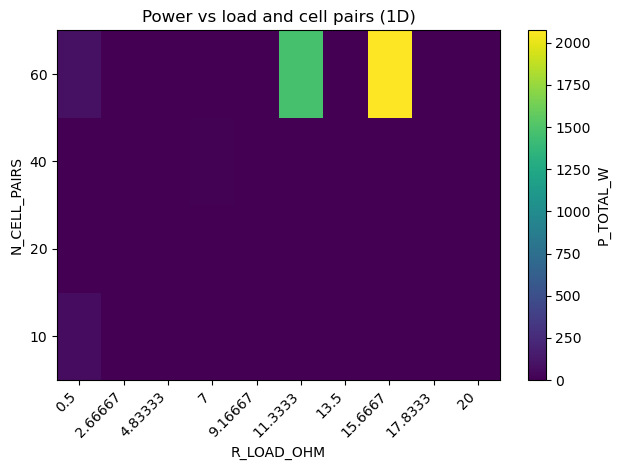

In [8]:
spec = SweepSpec(
    var1="R_LOAD_OHM",
    var1_values=np.linspace(0.5, 20.0, 10),
    var2="N_CELL_PAIRS",
    var2_values=np.array([10, 20, 40, 60], dtype=float),
)

df = run_regime_map(
    fixed_params=base,
    sweep_spec=spec,
    outputs_to_collect=("P_TOTAL_W", "V_TERM_V", "I_TOTAL_A"),
    which="1d",
    mode="fixed_load",
)

print(df.head())
heatmap_from_df(df, x="R_LOAD_OHM", y="N_CELL_PAIRS", z="P_TOTAL_W", title="Power vs load and cell pairs (1D)")


Rows: 324
   A_MEM_M2  N_CELL_PAIRS  P_TOTAL_W  P_DENS_W_M2      regime  converged  \
0    0.0025           5.0  12.120590   969.647177  conducting      False   
1    0.0025           6.0   0.000000     0.000000     blocked      False   
2    0.0025           8.0   0.000000     0.000000     blocked      False   
3    0.0025          10.0   2.724304   108.972151  conducting      False   
4    0.0025          13.0   0.000000     0.000000     blocked      False   

   any_kappa_oob  any_conc_clamped  any_inversion  
0          False             False          False  
1          False             False          False  
2          False             False          False  
3          False             False          False  
4          False             False          False  


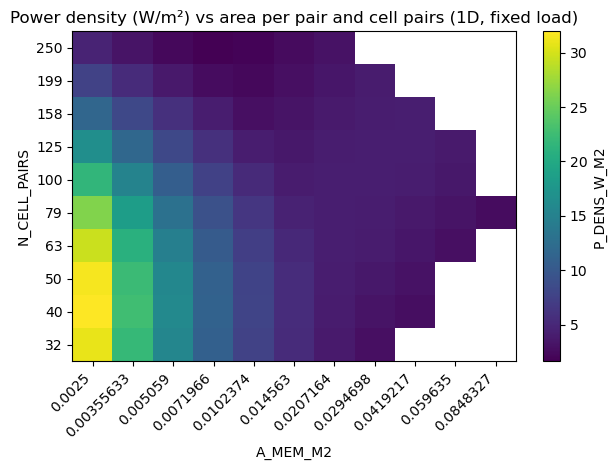

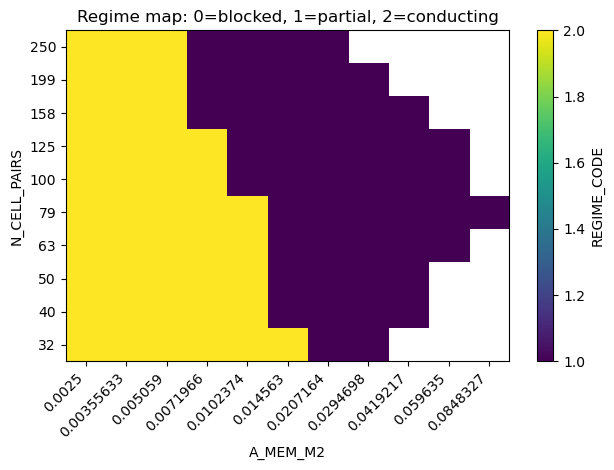

In [9]:
# -------------------------
# Wide-but-structured log sweep (2D): A_MEM_M2 vs N_CELL_PAIRS
# -------------------------

def logspace_int(lo: int, hi: int, n: int) -> np.ndarray:
    vals = np.unique(np.round(np.logspace(np.log10(lo), np.log10(hi), n)).astype(int))
    return vals

def logspace_float(lo: float, hi: float, n: int) -> np.ndarray:
    return np.logspace(np.log10(lo), np.log10(hi), n)

N_vals = logspace_int(5, 250, 18)
A_vals = logspace_float(0.0025, 1.0, 18)

spec_NA = SweepSpec(
    var1="A_MEM_M2",
    var1_values=A_vals,
    var2="N_CELL_PAIRS",
    var2_values=N_vals.astype(float),
)

# Fixed-load sweep to reveal blocked/partial/conducting regimes
base_wide = clone_params(base, MODE="fixed_load", R_LOAD_OHM=5.0, N_SEG=30)

df_NA = run_regime_map(
    fixed_params=base_wide,
    sweep_spec=spec_NA,
    outputs_to_collect=("P_TOTAL_W", "V_TERM_V", "I_TOTAL_A"),
    which="1d",
    mode="fixed_load",
)

print("Rows:", len(df_NA))
print(df_NA[["A_MEM_M2","N_CELL_PAIRS","P_TOTAL_W","P_DENS_W_M2","regime","converged","any_kappa_oob","any_conc_clamped","any_inversion"]].head())

# Filter to reliable points (adjust filters depending on what you want to visualize)
df_ok = df_NA.copy()
df_ok = df_ok[df_ok["converged"] == True]
df_ok = df_ok[df_ok["any_kappa_oob"] == False]

heatmap_from_df(df_ok, x="A_MEM_M2", y="N_CELL_PAIRS", z="P_DENS_W_M2",
                title="Power density (W/m²) vs area per pair and cell pairs (1D, fixed load)")

heatmap_from_df(df_ok, x="A_MEM_M2", y="N_CELL_PAIRS", z="REGIME_CODE",
                title="Regime map: 0=blocked, 1=partial, 2=conducting")
